Procedure 8.1



In [1]:
import requests
def make_request(endpoint, payload=None):
 """
 Make a request to a specific endpoint on the weather API
 passing headers and optional payload.

 Parameters:
 - endpoint: The endpoint of the API you want to
 make a GET request to.
 - payload: A dictionary of data to pass along
 with the request.

 Returns:
 Response object.
 """
 return requests.get(
 f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',
 headers={
 'token': 'nOrfLiLoGoVXWbNfzWUJSZkCrMTIDnuL'
 },
 params=payload
 )

In [5]:
import datetime
from IPython import display # for updating the cell dynamically
current = datetime.date(2018, 1, 1)
end = datetime.date(2019, 1, 1)
results = []
while current < end:
 # update the cell with status information
 display.clear_output(wait=True)
 display.display(f'Gathering data for {str(current)}')

 response = make_request(
 'data',
 {
 'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
 'locationid' : 'CITY:US360019', # NYC
 'startdate' : current,
 'enddate' : current,
 'units' : 'metric',
 'limit' : 1000 # max allowed
 }
 )
 if response.ok:
 # we extend the list instead of appending to avoid getting a nested list
  results.extend(response.json()['results'])
 # update the current date to avoid an infinite loop
 current += datetime.timedelta(days=1)

'Gathering data for 2018-12-31'

In [11]:
import pandas as pd

df = pd.DataFrame(results)
df.head()

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [15]:
df.to_csv('data/nyc_weather_2018.csv', index=False)

In [18]:
import sqlite3
with sqlite3.connect('data/weather.db') as connection:
 df.to_sql(
 'weather', connection, index=False, if_exists='replace'
 )

In [21]:
response = make_request(
 'stations',
 {
 'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
 'locationid' : 'CITY:US360019', # NYC
 'limit' : 1000 # max allowed
 }
)
stations = pd.DataFrame(response.json()['results'])[['id', 'name', 'latitude', 'longitude', 'elevation']]
stations.to_csv('data/weather_stations.csv', index=False)
with sqlite3.connect('data/weather.db') as connection:
 stations.to_sql(
 'stations', connection, index=False, if_exists='replace'
 )

Procedure 8.2

In [27]:
import pandas as pd
weather = pd.read_csv('data/nyc_weather_2018.csv')
weather.head()

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [29]:
snow_data = weather.query('datatype == "SNOW" and value > 0')
snow_data.head()

,date,datatype,station,attributes,value
127,2018-01-01T00:00:00,SNOW,GHCND:US1NYWC0019,",,N,1700",25.0
816,2018-01-04T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1600",229.0
819,2018-01-04T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0830",10.0
823,2018-01-04T00:00:00,SNOW,GHCND:US1NJBG0018,",,N,0910",46.0
830,2018-01-04T00:00:00,SNOW,GHCND:US1NJES0018,",,N,0700",10.0


In [31]:
import sqlite3
with sqlite3.connect('data/weather.db') as connection:
 snow_data_from_db = pd.read_sql(
 'SELECT * FROM weather WHERE datatype == "SNOW" AND value > 0',
 connection
 )
snow_data.reset_index().drop(columns='index').equals(snow_data_from_db)


True

In [35]:
weather[(weather.datatype == 'SNOW') & (weather.value > 0)].equals(snow_data)


True

In [37]:
station_info = pd.read_csv('data/weather_stations.csv')
station_info.head()


,id,name,latitude,longitude,elevation
0,GHCND:US1CTFR0022,"STAMFORD 2.6 SSW, CT US",41.064100,-73.577000,36.6
1,GHCND:US1CTFR0039,"STAMFORD 4.2 S, CT US",41.037788,-73.568176,6.4
2,GHCND:US1NJBG0001,"BERGENFIELD 0.3 SW, NJ US",40.921298,-74.001983,20.1
3,GHCND:US1NJBG0002,"SADDLE BROOK TWP 0.6 E, NJ US",40.902694,-74.083358,16.8
4,GHCND:US1NJBG0003,"TENAFLY 1.3 W, NJ US",40.914670,-73.977500,21.6


In [39]:
weather.head()

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [41]:
station_info.id.describe()

count                   330
unique                  330
top       GHCND:US1CTFR0022
freq                      1
Name: id, dtype: object

In [43]:
weather.station.describe()


count                 90033
unique                  114
top       GHCND:USW00014734
freq                   6647
Name: station, dtype: object

In [45]:
station_info.shape[0], weather.shape[0]


(330, 90033)

In [47]:
def get_row_count(*dfs):
 return [df.shape[0] for df in dfs]
get_row_count(station_info, weather)


[330, 90033]

In [49]:
def get_info(attr, *dfs):
 return list(map(lambda x: getattr(x, attr), dfs))
get_info('shape', station_info, weather)


[(330, 5), (90033, 5)]

In [51]:
inner_join = weather.merge(station_info, left_on='station', right_on='id')
inner_join.sample(5, random_state=0)

,date,datatype,station,attributes,value,id,name,latitude,longitude,elevation
25996,2018-04-13T00:00:00,WDF2,GHCND:USW00094741,",,W,",210.0,GHCND:USW00094741,"TETERBORO AIRPORT, NJ US",40.858980,-74.056160,0.8
4196,2018-01-18T00:00:00,PRCP,GHCND:USW00014732,",,W,2400",0.0,GHCND:USW00014732,"LAGUARDIA AIRPORT, NY US",40.779450,-73.880270,3.0
74999,2018-11-03T00:00:00,WT08,GHCND:USW00014734,",,W,",1.0,GHCND:USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",40.682750,-74.169270,1.9
9925,2018-02-09T00:00:00,PRCP,GHCND:US1NYNS0042,",,N,0730",0.0,GHCND:US1NYNS0042,"ALBERTSON 0.2 SSE, NY US",40.769131,-73.647484,43.3
79614,2018-11-21T00:00:00,WDF5,GHCND:USW00094789,",,W,",320.0,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.639150,-73.763900,2.7


In [53]:
weather.merge(station_info.rename(dict(id='station'), axis=1), on='station').sample(5, random_state=0)


,date,datatype,station,attributes,value,name,latitude,longitude,elevation
25996,2018-04-13T00:00:00,WDF2,GHCND:USW00094741,",,W,",210.0,"TETERBORO AIRPORT, NJ US",40.858980,-74.056160,0.8
4196,2018-01-18T00:00:00,PRCP,GHCND:USW00014732,",,W,2400",0.0,"LAGUARDIA AIRPORT, NY US",40.779450,-73.880270,3.0
74999,2018-11-03T00:00:00,WT08,GHCND:USW00014734,",,W,",1.0,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",40.682750,-74.169270,1.9
9925,2018-02-09T00:00:00,PRCP,GHCND:US1NYNS0042,",,N,0730",0.0,"ALBERTSON 0.2 SSE, NY US",40.769131,-73.647484,43.3
79614,2018-11-21T00:00:00,WDF5,GHCND:USW00094789,",,W,",320.0,"JFK INTERNATIONAL AIRPORT, NY US",40.639150,-73.763900,2.7


In [55]:
left_join = station_info.merge(weather, left_on='id', right_on='station', how='left')
right_join = weather.merge(station_info, left_on='station', right_on='id', how='right')
right_join.tail()

,date,datatype,station,attributes,value,id,name,latitude,longitude,elevation
90244,2018-12-31T00:00:00,WDF5,GHCND:USW00094789,",,W,",130.0,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.7639,2.7
90245,2018-12-31T00:00:00,WSF2,GHCND:USW00094789,",,W,",9.8,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.7639,2.7
90246,2018-12-31T00:00:00,WSF5,GHCND:USW00094789,",,W,",12.5,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.7639,2.7
90247,2018-12-31T00:00:00,WT01,GHCND:USW00094789,",,W,",1.0,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.7639,2.7
90248,2018-12-31T00:00:00,WT02,GHCND:USW00094789,",,W,",1.0,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.7639,2.7


In [57]:
left_join.sort_index(axis=1).sort_values(['date', 'station']).reset_index().drop(columns='index').equals(
 right_join.sort_index(axis=1).sort_values(['date', 'station']).reset_index().drop(columns='index')
)


True

In [59]:
get_info('shape', inner_join, left_join, right_join)


[(90033, 10), (90249, 10), (90249, 10)]

In [63]:
outer_join = weather.merge(
 station_info[station_info.name.str.contains('NY')],
 left_on='station', right_on='id', how='outer', indicator=True
)
outer_join.sample(4, random_state=0).append(outer_join[outer_join.station.isna()].head(2))

AttributeError: 'DataFrame' object has no attribute 'append'

In [64]:
import sqlite3
with sqlite3.connect('data/weather.db') as connection:
 inner_join_from_db = pd.read_sql(
 'SELECT * FROM weather JOIN stations ON weather.station == stations.id',
 connection
 )
inner_join_from_db.shape == inner_join.shape

True

In [68]:
dirty_data = pd.read_csv(
 'data/dirty_data.csv', index_col='date'
).drop_duplicates().drop(columns='SNWD')
dirty_data.head()

,station,PRCP,SNOW,TMAX,TMIN,TOBS,WESF,inclement_weather
date,,,,,,,,
2018-01-01T00:00:00,?,0.0,0.0,5505.0,-40.0,NaN,NaN,NaN
2018-01-02T00:00:00,GHCND:USC00280907,0.0,0.0,-8.3,-16.1,-12.2,NaN,False
2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-4.4,-13.9,-13.3,NaN,False
2018-01-04T00:00:00,?,20.6,229.0,5505.0,-40.0,NaN,19.3,True
2018-01-05T00:00:00,?,0.3,NaN,5505.0,-40.0,NaN,NaN,NaN


In [70]:
valid_station = dirty_data.query('station != "?"').copy().drop(columns=['WESF', 'station'])
station_with_wesf = dirty_data.query('station == "?"').copy().drop(columns=['station', 'TOBS', 'TMIN', 'TMAX'])


In [72]:
valid_station.merge(
 station_with_wesf, left_index=True, right_index=True
).query('WESF > 0').head()


,PRCP_x,SNOW_x,TMAX,TMIN,TOBS,inclement_weather_x,PRCP_y,SNOW_y,WESF,inclement_weather_y
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [74]:
valid_station.merge(
 station_with_wesf, left_index=True, right_index=True, suffixes=('', '_?')
).query('WESF > 0').head()

,PRCP,SNOW,TMAX,TMIN,TOBS,inclement_weather,PRCP_?,SNOW_?,WESF,inclement_weather_?
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [76]:
valid_station.join(station_with_wesf, rsuffix='_?').query('WESF > 0').head()


,PRCP,SNOW,TMAX,TMIN,TOBS,inclement_weather,PRCP_?,SNOW_?,WESF,inclement_weather_?
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [78]:
weather.set_index('station', inplace=True)
station_info.set_index('id', inplace=True)


In [80]:
 weather.index.intersection(station_info.index)

Index(['GHCND:US1CTFR0039', 'GHCND:US1NJBG0015', 'GHCND:US1NJBG0017',
       'GHCND:US1NJBG0018', 'GHCND:US1NJBG0023', 'GHCND:US1NJBG0030',
       'GHCND:US1NJBG0039', 'GHCND:US1NJBG0044', 'GHCND:US1NJES0018',
       'GHCND:US1NJES0024',
       ...
       'GHCND:USC00284987', 'GHCND:US1NJES0031', 'GHCND:US1NJES0029',
       'GHCND:US1NJMD0086', 'GHCND:US1NJMS0097', 'GHCND:US1NJMN0081',
       'GHCND:US1NJMD0088', 'GHCND:US1NJES0033', 'GHCND:US1NJES0040',
       'GHCND:US1NYQN0029'],
      dtype='object', length=114)

In [82]:
weather.index.difference(station_info.index)


Index([], dtype='object')

In [84]:
station_info.index.difference(weather.index)


Index(['GHCND:US1CTFR0022', 'GHCND:US1NJBG0001', 'GHCND:US1NJBG0002',
       'GHCND:US1NJBG0005', 'GHCND:US1NJBG0006', 'GHCND:US1NJBG0008',
       'GHCND:US1NJBG0011', 'GHCND:US1NJBG0012', 'GHCND:US1NJBG0013',
       'GHCND:US1NJBG0020',
       ...
       'GHCND:USC00308749', 'GHCND:USC00308946', 'GHCND:USC00309117',
       'GHCND:USC00309270', 'GHCND:USC00309400', 'GHCND:USC00309466',
       'GHCND:USC00309576', 'GHCND:USC00309580', 'GHCND:USW00014708',
       'GHCND:USW00014786'],
      dtype='object', length=216)

In [86]:
ny_in_name = station_info[station_info.name.str.contains('NY')]
ny_in_name.index.difference(weather.index).shape[0]\
+ weather.index.difference(ny_in_name.index).shape[0]\
== weather.index.symmetric_difference(ny_in_name.index).shape[0]

True

In [88]:
weather.index.unique().union(station_info.index)

Index(['GHCND:US1CTFR0022', 'GHCND:US1CTFR0039', 'GHCND:US1NJBG0001',
       'GHCND:US1NJBG0002', 'GHCND:US1NJBG0003', 'GHCND:US1NJBG0005',
       'GHCND:US1NJBG0006', 'GHCND:US1NJBG0008', 'GHCND:US1NJBG0010',
       'GHCND:US1NJBG0011',
       ...
       'GHCND:USW00014708', 'GHCND:USW00014732', 'GHCND:USW00014734',
       'GHCND:USW00014786', 'GHCND:USW00054743', 'GHCND:USW00054787',
       'GHCND:USW00094728', 'GHCND:USW00094741', 'GHCND:USW00094745',
       'GHCND:USW00094789'],
      dtype='object', length=330)

In [90]:
ny_in_name = station_info[station_info.name.str.contains('NY')]
ny_in_name.index.difference(weather.index).union(weather.index.difference(ny_in_name.index)).equals(
 weather.index.symmetric_difference(ny_in_name.index)
)

True

Procedure 8.3

In [92]:
import numpy as np
import pandas as pd
weather = pd.read_csv('data/nyc_weather_2018.csv', parse_dates=['date'])
weather.head()

,date,datatype,station,attributes,value
0,2018-01-01,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [96]:
fb = pd.read_csv('data/fb_2018.csv', index_col='date', parse_dates=True)
fb.head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903
2018-01-03,181.88,184.78,181.3300,184.67,16886563
2018-01-04,184.90,186.21,184.0996,184.33,13880896
2018-01-05,185.59,186.90,184.9300,186.85,13574535
2018-01-08,187.20,188.90,186.3300,188.28,17994726


In [98]:
fb.assign(
 abs_z_score_volume=lambda x: x.volume.sub(x.volume.mean()).div(x.volume.std()).abs()
).query('abs_z_score_volume > 3')

,open,high,low,close,volume,abs_z_score_volume
date,,,,,,
2018-03-19,177.01,177.17,170.06,172.56,88140060,3.145078
2018-03-20,167.47,170.20,161.95,168.15,129851768,5.315169
2018-03-21,164.80,173.40,163.30,169.39,106598834,4.105413
2018-03-26,160.82,161.10,149.02,160.06,126116634,5.120845
2018-07-26,174.89,180.13,173.75,176.26,169803668,7.393705


In [103]:
fb.assign(
 volume_pct_change=fb.volume.pct_change(),
 pct_change_rank=lambda x: x.volume_pct_change.abs().rank(
 ascending=False
 )
).nsmallest(5, 'pct_change_rank')


,open,high,low,close,volume,volume_pct_change,pct_change_rank
date,,,,,,,
2018-01-12,178.06,181.48,177.40,179.37,77551299,7.087876,1.0
2018-03-19,177.01,177.17,170.06,172.56,88140060,2.611789,2.0
2018-07-26,174.89,180.13,173.75,176.26,169803668,1.628841,3.0
2018-09-21,166.64,167.25,162.81,162.93,45994800,1.428956,4.0
2018-03-26,160.82,161.10,149.02,160.06,126116634,1.352496,5.0


In [105]:
fb['2018-01-11':'2018-01-12']

,open,high,low,close,volume
date,,,,,
2018-01-11,188.40,188.40,187.38,187.77,9588587
2018-01-12,178.06,181.48,177.40,179.37,77551299


In [107]:
(fb > 215).any()


open       True
high       True
low       False
close      True
volume     True
dtype: bool

In [109]:
(fb.volume.value_counts() > 1).sum()


0

In [111]:
volume_binned = pd.cut(fb.volume, bins=3, labels=['low', 'med', 'high'])
volume_binned.value_counts()

volume
low     240
med       8
high      3
Name: count, dtype: int64

In [113]:
fb[volume_binned == 'high'].sort_values(
 'volume', ascending=False
)

,open,high,low,close,volume
date,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668
2018-03-20,167.47,170.20,161.95,168.15,129851768
2018-03-26,160.82,161.10,149.02,160.06,126116634


In [115]:
fb['2018-07-25':'2018-07-26']


,open,high,low,close,volume
date,,,,,
2018-07-25,215.715,218.62,214.27,217.50,64592585
2018-07-26,174.890,180.13,173.75,176.26,169803668


In [117]:
fb['2018-03-16':'2018-03-20']

,open,high,low,close,volume
date,,,,,
2018-03-16,184.49,185.33,183.41,185.09,24403438
2018-03-19,177.01,177.17,170.06,172.56,88140060
2018-03-20,167.47,170.20,161.95,168.15,129851768


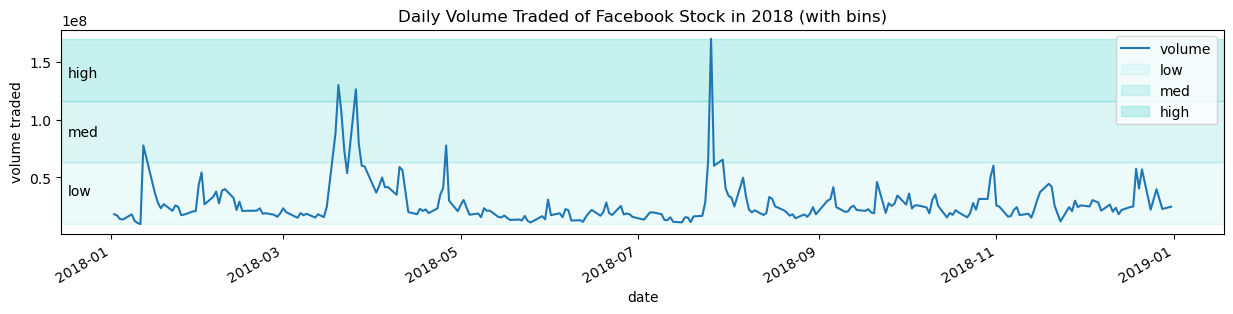

In [121]:
import matplotlib.pyplot as plt

fb.plot(y='volume', figsize=(15, 3), title='Daily Volume Traded of Facebook Stock in 2018 (with bins)')
for bin_name, alpha, bounds in zip(
 ['low', 'med', 'high'], [0.1, 0.2, 0.3], pd.cut(fb.volume, bins=3).unique().categories.values
):
 plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
 plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))

plt.ylabel('volume traded')
plt.legend()
plt.show()


In [123]:
volume_qbinned = pd.qcut(fb.volume, q=4, labels=['q1', 'q2', 'q3', 'q4'])
volume_qbinned.value_counts()

volume
q1    63
q2    63
q4    63
q3    62
Name: count, dtype: int64

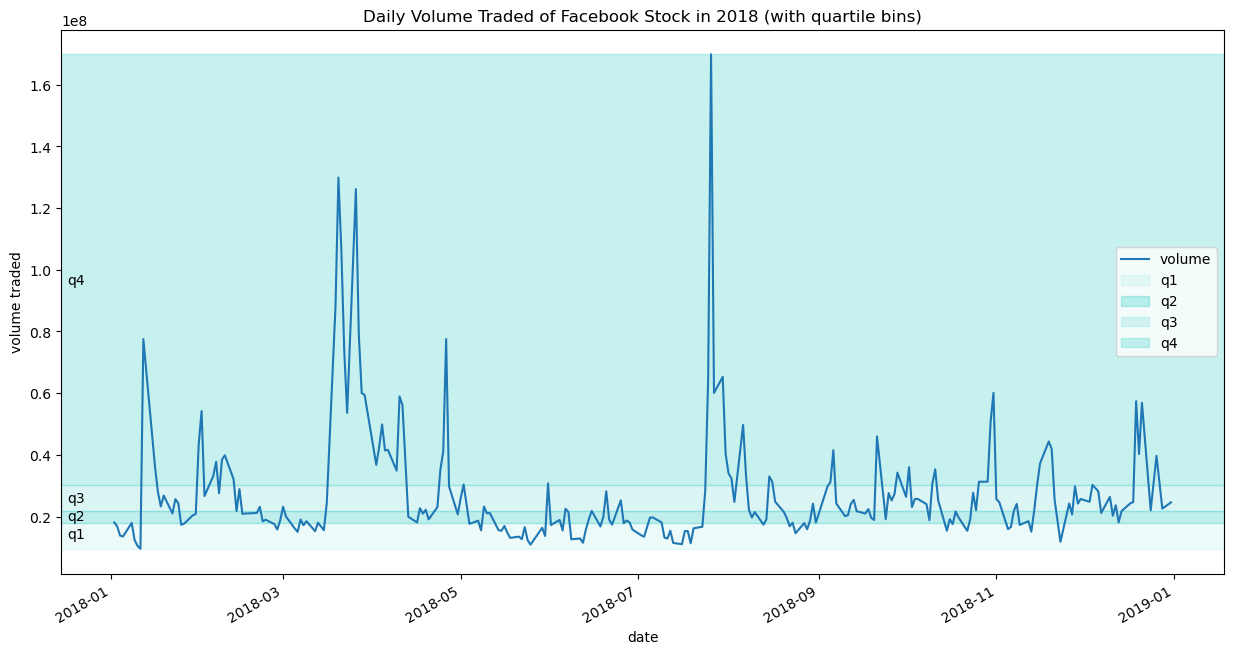

In [125]:
fb.plot(y='volume', figsize=(15, 8), title='Daily Volume Traded of Facebook Stock in 2018 (with quartile bins)')
for bin_name, alpha, bounds in zip(
 ['q1', 'q2', 'q3', 'q4'], [0.1, 0.35, 0.2, 0.3], pd.qcut(fb.volume, q=4).unique().categories.values
):
 plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
 plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))

plt.ylabel('volume traded')
plt.legend()
plt.show()

In [135]:
central_park_weather = weather.query(
 'station == "GHCND:USW00094728"'
).pivot(index='date', columns='datatype', values='value')

In [137]:
central_park_weather.SNOW.clip(0, 1).value_counts()


SNOW
0.0    345
1.0     11
Name: count, dtype: int64

In [139]:
oct_weather_z_scores = central_park_weather.loc[
 '2018-10', ['TMIN', 'TMAX', 'PRCP']
].apply(lambda x: x.sub(x.mean()).div(x.std()))
oct_weather_z_scores.describe().T


,count,mean,std,min,25%,50%,75%,max
datatype,,,,,,,,
TMIN,31.0,-1.790682e-16,1.0,-1.339112,-0.751019,-0.474269,1.065152,1.843511
TMAX,31.0,1.951844e-16,1.0,-1.305582,-0.870013,-0.138258,1.011643,1.604016
PRCP,31.0,1.038596e-16,1.0,-0.394438,-0.394438,-0.394438,-0.240253,3.936167


In [141]:
oct_weather_z_scores.query('PRCP > 3')

datatype,TMIN,TMAX,PRCP
date,,,
2018-10-27,-0.751019,-1.201045,3.936167


In [143]:
central_park_weather.loc['2018-10', 'PRCP'].describe()

count    31.000000
mean      2.941935
std       7.458542
min       0.000000
25%       0.000000
50%       0.000000
75%       1.150000
max      32.300000
Name: PRCP, dtype: float64

In [147]:
import numpy as np
fb.apply(
 lambda x: np.vectorize(lambda y: len(str(np.ceil(y))))(x)
).astype('int64').equals(
 fb.applymap(lambda x: len(str(np.ceil(x))))
)


C:\Users\user\AppData\Local\Temp\ipykernel_8648\1622588739.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fb.applymap(lambda x: len(str(np.ceil(x))))


True

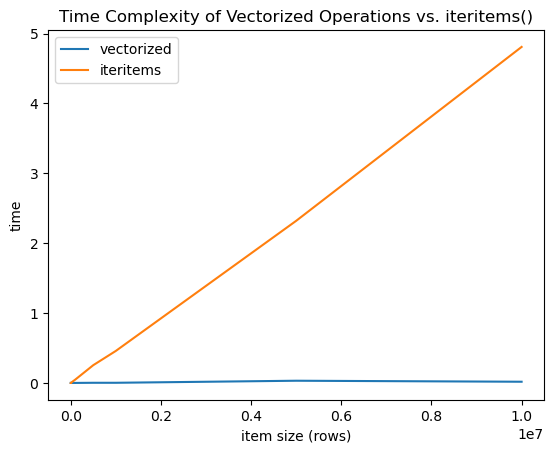

In [153]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(0)
vectorized_results = {}
iteritems_results = {}
for size in [10, 100, 1000, 10000, 100000, 500000, 1000000, 5000000, 10000000]:
    test = pd.Series(np.random.uniform(size=size))

    start = time.time()
    x = test + 10
    end = time.time()
    vectorized_results[size] = end - start

    start = time.time()
    x = []
    for i, v in test.items():
     x.append(v + 10)
    x = pd.Series(x)
    end = time.time()
    iteritems_results[size] = end - start
    
pd.DataFrame(
 [pd.Series(vectorized_results, name='vectorized'), pd.Series(iteritems_results, name='iteritems')]
).T.plot(title='Time Complexity of Vectorized Operations vs. iteritems()')
plt.xlabel('item size (rows)')
plt.ylabel('time')
plt.show()

In [175]:
central_park_weather['2018-10-01':'2018-10-07'].assign(
 rolling_PRCP=lambda x: x.PRCP.rolling('3D').sum()
)[['PRCP', 'rolling_PRCP']].head(7).T


date,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07
datatype,,,,,,,
PRCP,0.0,17.5,0.0,1.0,0.0,0.0,0.0
rolling_PRCP,0.0,17.5,17.5,18.5,1.0,1.0,0.0


In [177]:
central_park_weather['2018-10-01':'2018-10-07'].rolling('3D').mean().head(7).iloc[:,:6]


datatype,ADPT,ASLP,ASTP,AWBT,AWND,PRCP
date,,,,,,
2018-10-01,172.000000,10247.000000,10200.000000,189.000000,0.900000,0.000000
2018-10-02,180.500000,10221.500000,10176.000000,194.500000,0.900000,8.750000
2018-10-03,172.333333,10205.333333,10159.000000,187.000000,0.966667,5.833333
2018-10-04,176.000000,10175.000000,10128.333333,187.000000,0.800000,6.166667
2018-10-05,155.666667,10177.333333,10128.333333,170.333333,1.033333,0.333333
2018-10-06,157.333333,10194.333333,10145.333333,170.333333,0.833333,0.333333
2018-10-07,163.000000,10217.000000,10165.666667,177.666667,1.066667,0.000000


In [173]:
central_park_weather['2018-10-01':'2018-10-07'].rolling('3D').agg(
 {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'}
).join( # join with original data for comparison
 central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']],
 lsuffix='_rolling'
).sort_index(axis=1) # sort columns so rolling calcs are next to originals

datatype,AWND,AWND_rolling,PRCP,PRCP_rolling,TMAX,TMAX_rolling,TMIN,TMIN_rolling
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.800000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,1.033333,0.0,1.0,21.7,24.4,15.6,15.6
2018-10-06,0.5,0.833333,0.0,1.0,20.0,24.4,17.2,15.6
2018-10-07,1.1,1.066667,0.0,0.0,26.1,26.1,19.4,15.6


In [181]:
central_park_weather.PRCP.expanding().sum().equals(central_park_weather.PRCP.cumsum())

False

In [185]:
central_park_weather['2018-10-01':'2018-10-07'].expanding().agg(
 {'TMAX': np.max, 'TMIN': np.min, 'AWND': np.mean, 'PRCP': np.sum}
).join(
 central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']],
 lsuffix='_expanding'
).sort_index(axis=1)

C:\Users\user\AppData\Local\Temp\ipykernel_8648\3438569374.py:1: FutureWarning: The provided callable <function max at 0x000001A3E0BF7560> is currently using Expanding.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  central_park_weather['2018-10-01':'2018-10-07'].expanding().agg(
C:\Users\user\AppData\Local\Temp\ipykernel_8648\3438569374.py:1: FutureWarning: The provided callable <function min at 0x000001A3E0BF76A0> is currently using Expanding.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  central_park_weather['2018-10-01':'2018-10-07'].expanding().agg(
C:\Users\user\AppData\Local\Temp\ipykernel_8648\3438569374.py:1: FutureWarning: The provided callable <function mean at 0x000001A3E0BF7F60> is currently using Expanding.mean. In a future version of pandas, the provided callable will be used directly. To ke

datatype,AWND,AWND_expanding,PRCP,PRCP_expanding,TMAX,TMAX_expanding,TMIN,TMIN_expanding
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.825000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,0.980000,0.0,18.5,21.7,25.0,15.6,15.6
2018-10-06,0.5,0.900000,0.0,18.5,20.0,25.0,17.2,15.6
2018-10-07,1.1,0.928571,0.0,18.5,26.1,26.1,19.4,15.6


In [187]:

fb.assign(
 close_ewma=lambda x: x.close.ewm(span=5).mean()
).tail(10)[['close', 'close_ewma']]

,close,close_ewma
date,,
2018-12-17,140.19,142.235433
2018-12-18,143.66,142.710289
2018-12-19,133.24,139.553526
2018-12-20,133.40,137.502350
2018-12-21,124.95,133.318234
2018-12-24,124.06,130.232156
2018-12-26,134.18,131.548104
2018-12-27,134.52,132.538736
2018-12-28,133.20,132.759157


In [9]:
def get_info(df):
 return '%d rows and %d columns and max closing z-score was %d' % (*df.shape, df.close.max())
fb['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()).pipe(get_info)\
 == get_info(fb['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()))


NameError: name 'fb' is not defined

In [193]:
fb.pipe(pd.DataFrame.rolling, '20D').mean().equals(fb.rolling('20D').mean())


True

In [195]:
pd.DataFrame.rolling(fb, '20D').mean().equals(fb.rolling('20D').mean())


True

In [197]:
from window_calc import window_calc
window_calc??

ModuleNotFoundError: No module named 'window_calc'